In [1]:
import matplotlib.pyplot as plt
from pyscf import gto, scf
from scf_guess.metrics import f_score

In [2]:
mol = gto.M(
    atom="../data/test_data/geometries/W4-17/hoclo.xyz",
    basis="pcseg-0",
    spin=0,
    symmetry=False,
)

In [3]:
# Run Hartree-Fock calculation to obtain a converged density
mf = scf.RHF(mol).run()
print(f"Final energy: {mf.energy_tot()} Ha")

mo1, _, stable, _ = mf.stability(return_status=True)
while not stable:
    dm1 = mf.make_rdm1(mo1, mf.mo_occ)
    mf = mf.run(dm1)
    mo1, _, stable, _ = mf.stability(return_status=True)

# Factor two to account for double occupation
final_dm = mf.make_rdm1() / 2

converged SCF energy = -608.459845492513
Final energy: -608.4598454925133 Ha
<class 'pyscf.scf.hf.RHF'> wavefunction is stable in the internal stability analysis


In [4]:
def build_guess(guess="1e"):
    mf = scf.RHF(mol)
    guess_dens = mf.get_init_guess(key=guess)
    # Factor two to account for double occupation
    return guess_dens / 2

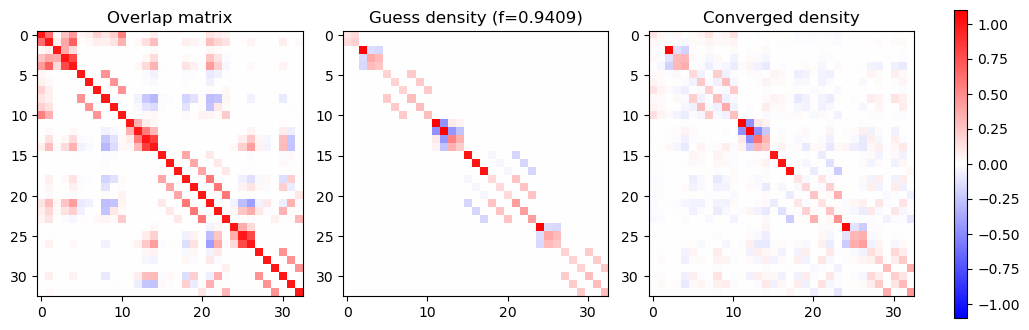

In [5]:
S = mf.get_ovlp()
# Similar to SAD guess
guess_dm = build_guess("atom")

imshow_kwargs = dict(vmin=-1.1, vmax=1.1, cmap="bwr")
fig, ax = plt.subplots(figsize=(12, 4), ncols=4, width_ratios=[1, 1, 1, 0.05])
ax[0].imshow(S, **imshow_kwargs)
ax[0].set_title("Overlap matrix")

ax[1].imshow(guess_dm, **imshow_kwargs)
ax[1].set_title(f"Guess density (f={f_score(S, final_dm, guess_dm):.4f})")

p = ax[2].imshow(final_dm, **imshow_kwargs)
ax[2].set_title("Converged density")

plt.colorbar(p, cax=ax[-1])

# Different initial guesses

Lets try to reproduce the corresponding row from Supporting Information Table S5:

| Molecule | GWH   | CORE  | SAD   | SADNO | HUCKEL | GSZ   | LDA-X | CAP-X | CHA-X |  
| -------- | ----- | ----- | ----- | ----- | ------ | ----- | ----- | ----- | ----- |
| hoclo    | 0.628 | 0.740 | 0.936 | 0.977 | 0.984  | 0.974 | 0.994 | 0.993 | 0.994 |

In [6]:
# All available initial guess options in pyscf
# (from: https://github.com/pyscf/pyscf/blob/9a0bb6ddded7049bdacdaf4cfe422f7ce826c2c7/pyscf/scf/hf.py#L1940)
guesses = ["minao", "hcore", "huckel", "mod_huckel", "atom", "sap"]
for guess in guesses:
    guess_dm = build_guess(guess=guess)
    f = f_score(S, final_dm, guess_dm)
    print(f"{guess:>10s}: {f:.3f}")

     minao: 0.936
     hcore: 0.740
    huckel: 0.991
mod_huckel: 0.988
      atom: 0.941
Found SAP basis sapgrasplarge
       sap: 0.993
